In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [4]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(' ', '_')
label = adata.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [4]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4 T,CD4_TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [5]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\feature_selection_k3")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [6]:
features_dict.keys()

dict_keys(['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC'])

In [7]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,47,25
B_intermediate,96,49
B_memory,170,90
B_naive,9,6
CD14_Mono,29,16
CD16_Mono,37,17
CD4_CTL,122,45
CD4_Naive,730,393
CD4_Proliferating,70,35
CD4_TCM,247,133


## Build classifiers (K-fold CV)

In [8]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }

    print('Cross validation...')
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    # cv_results = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=32)
    ## Use training set in cross_validate()
    cv_results = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=32)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [ ]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    # filename = f'LR_{celltype}_Harmony_l2.pkl'
    # with open(filename, 'wb') as f:
    #     pickle.dump(clf, f)


K-fold CV for: ASDC
Cross validation...
[0.9999227271146449, 0.9714285714285715, 0.8705128205128204, 0.913469139556096, 0.9999722973843577, 0.9672119090346645, 0.9171742748162377]
K-fold CV for: B_intermediate
Cross validation...
[0.9948613314789855, 0.8537875385106302, 0.7948586118251928, 0.8229978247313605, 0.997551970237233, 0.8997888511877564, 0.821074269518866]
K-fold CV for: B_memory
Cross validation...
[0.9975736220850788, 0.9430854513294886, 0.9372225239905848, 0.94004852679462, 0.9993985657109615, 0.9850398347034337, 0.9388652695479618]
K-fold CV for: B_naive
Cross validation...
[0.9955181550349336, 0.9528927658920525, 0.9531894566237312, 0.9530315993474929, 0.9993713899584662, 0.9861802431907483, 0.9506836570934956]
K-fold CV for: CD14_Mono
Cross validation...
[0.9908276810118615, 0.9779705483188204, 0.9874970684201061, 0.9827076504096508, 0.9988368304063793, 0.994663523398209, 0.9764904791302135]
K-fold CV for: CD16_Mono
Cross validation...
[0.9944054227391567, 0.92637617873

In [ ]:
# cv_results = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=32)
# all_metrics

In [10]:
# cv_results = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=32)
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999923,0.971429,0.870513,0.913469,0.999972,0.967212,0.917174
B_intermediate,0.994861,0.853788,0.794859,0.822998,0.997552,0.899789,0.821074
B_memory,0.997574,0.943085,0.937223,0.940049,0.999399,0.985040,0.938865
B_naive,0.995518,0.952893,0.953189,0.953032,0.999371,0.986180,0.950684
CD14_Mono,0.990828,0.977971,0.987497,0.982708,0.998837,0.994664,0.976490
CD16_Mono,0.994405,0.926376,0.930970,0.928584,0.999177,0.979097,0.925721
CD4_CTL,0.996654,0.868805,0.810687,0.838637,0.997786,0.918123,0.837514
CD4_Naive,0.985094,0.927224,0.935565,0.931344,0.997284,0.978407,0.923015
CD4_Proliferating,0.999722,0.816109,0.756863,0.782893,0.999849,0.869824,0.784550
CD4_TCM,0.968465,0.838747,0.813869,0.826109,0.989516,0.900690,0.808892


In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/LR_likelihood')
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_l2_k3_stratifiedKF.csv')

## Plot classifier K-fold CV metrics

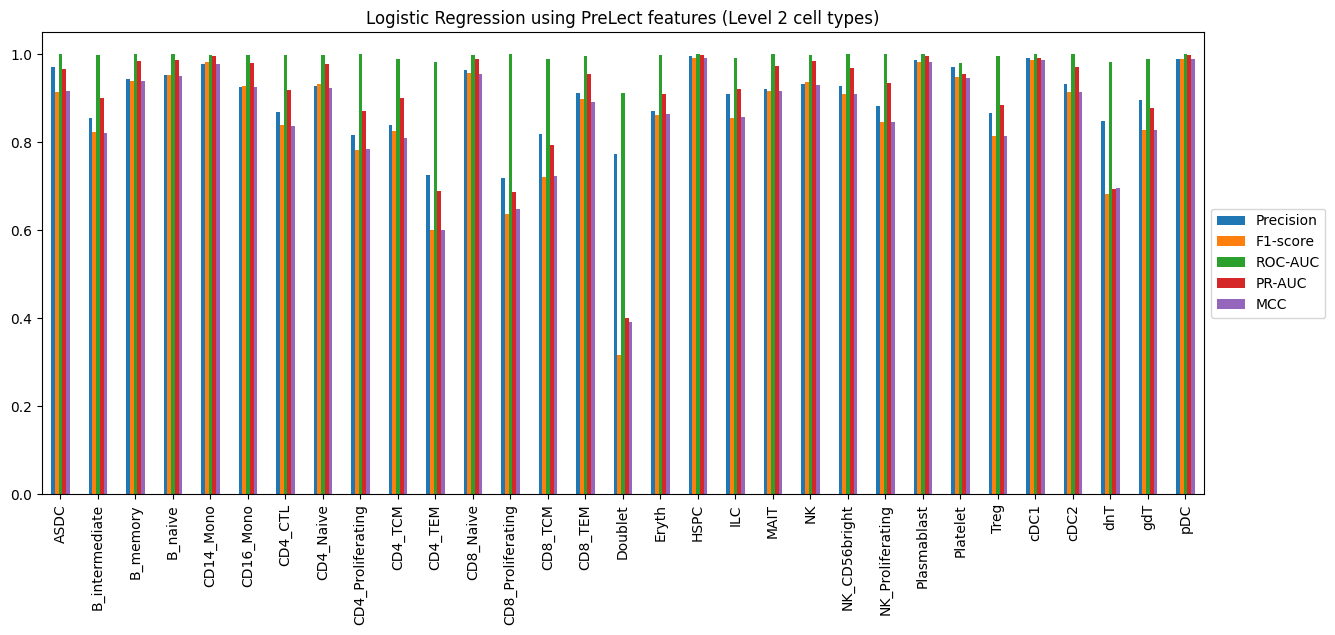

In [12]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']

# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=90, figsize=(15,6), title='Logistic Regression using PreLect features (Level 2 cell types)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Get likelihood from LR model

In [16]:
def LR_likelihood_pred_prob(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return likelihood


In [ ]:
celltype = 'B'
B_likelihood = LR_likelihood_pred_prob(adata, features_dict, celltype)
B_likelihood.shape

In [ ]:
B_likelihood[:5]

In [ ]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood_pred_prob(adata, features_dict, celltype)

In [ ]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

In [ ]:
likelihood_df.shape

In [ ]:
# row sum
likelihood_df.sum(axis=1)


In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/LR_likelihood')
likelihood_df.to_csv('l2_likelihood_df_k3.csv')

## Assign the celltype with the largest likelihood (no odds ratio)

In [ ]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


In [ ]:
result_df.head(20)

## Confusion heatmap

In [23]:
import pandas as pd

# Get the true labels
true_labels = adata.obs['celltype.l2'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
# cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [ ]:
cm

In [25]:
cm.to_csv('likelihood_assignment_confusion_matrix_k3.csv')

## Plot confusion matrix

In [3]:
import os
os.chdir('./LR_likelihood')
cm = pd.read_csv('likelihood_assignment_confusion_matrix_k3.csv', index_col=0)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
row_sum = cm.sum(axis=1)
row_sum


In [ ]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(10, 10))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.savefig('cm_plot.png', dpi=300)
plt.show()

## Calculate accuracy

In [ ]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

In [ ]:
cm.values.sum()